# Sentiment Analysis with Pyspark

In [5]:
import findspark
findspark.init('/home/matt/spark-3.1.1-bin-hadoop2.7')

import pyspark as ps
import warnings
from pyspark.sql import SQLContext

import pandas as pd
import numpy as np

In [3]:
# create SparkContext on available CPUs 
sc = ps.SparkContext('local[2]')
sqlContext = SQLContext(sc)

## Import stored dataset

In [ ]:
cols = ['sentiment','id','date','query_string','user','text']

In [ ]:
df = pd.read_csv("./training.1600000.processed.noemoticon.csv",header=None, names=cols)

In [ ]:
df.head(5)

In [ ]:
# drop unnecessary columns
df.drop(['id','date','query_string','user'],axis=1,inplace=True)

In [ ]:
df.head(5)

In [ ]:
# plot distribution of tweet sentiments
import seaborn as sns
sns.displot(df,x='sentiment')

In [ ]:
# map to 0 and 1
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

## Clean data of unnecessay text, e.g. HTML, '@', URL, etc.

In [ ]:
# remove HTML decoding
from bs4 import BeautifulSoup #wrangle lxml
import re # to remove tags
from nltk.tokenize import WordPunctTokenizer

In [ ]:
tok = WordPunctTokenizer()

In [ ]:
# define cleaner function variables
mentions = r'@[A-Za-z0-9]+'
urls = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((mentions, urls))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

# define cleaner functions
def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [ ]:
# check original data
before_clean = df.text[100]
before_clean

In [ ]:
# clean data
cleaned_text = tweet_cleaner(before_clean)
cleaned_text

In [ ]:
# now clean all tweets - takes a long time to do all 1.6 million tweets!
print("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in df.index:            
    if((i+1)%100000 == 0 ):
        print ("Tweets %d of %d has been processed" % (i+1, len(df)))
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

In [ ]:
#check for null data created by cleaning process
np.sum(df.isnull().any(axis=1))

In [ ]:
# delete rows containing missing data
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.info()

## Save cleaned data

In [ ]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment

In [ ]:
clean_df.head(5)

In [ ]:
clean_df.to_csv('clean_tweet.csv',encoding='utf-8')

# Create Sentiment Analysis models

## Test baseline sentiment using TextBlob

In [25]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [63]:
tdf = pd.read_csv("clean_tweet.csv",index_col=0)
tdf.dropna(inplace=True)
tdf.reset_index(drop=True,inplace=True)
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596753 entries, 0 to 1596752
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596753 non-null  object
 1   target  1596753 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [73]:
from sklearn.model_selection import train_test_split
x = tdf.text
y = tdf.target

0          0
1          0
2          0
3          0
4          0
          ..
1596748    1
1596749    1
1596750    1
1596751    1
1596752    1
Name: target, Length: 1596753, dtype: int64

In [75]:
# split data to be similar percentage of df
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.1,random_state=1)

In [76]:
%%time
# measure polarity of tweets
tbresult = [TextBlob(i).sentiment.polarity for i in x_test]
tbpred = [0 if n < 0 else 1 for n in tbresult]

CPU times: user 46.2 s, sys: 45 ms, total: 46.2 s
Wall time: 46.3 s


Accuracy Score: 61.21%
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.76      0.32      0.46     79782
           1       0.57      0.90      0.70     79894

    accuracy                           0.61    159676
   macro avg       0.67      0.61      0.58    159676
weighted avg       0.67      0.61      0.58    159676



<AxesSubplot:>

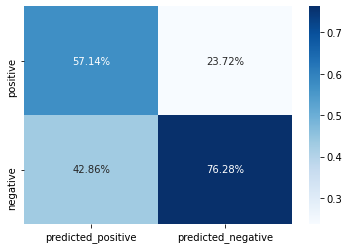

In [78]:
import seaborn as sns

# Calculate accuracy and create a confusion matrix output
conmat = np.array(confusion_matrix(y_test, tbpred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])

print("Accuracy Score: {0:.2f}%".format(accuracy_score(y_test, tbpred)*100))
print("-"*80)
print("Classification Report\n")
print(classification_report(y_test, tbpred))

# plot confusion matrix
sns.heatmap(confusion/np.sum(confusion), annot=True, fmt='.2%',cmap='Blues')

## Train new models

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('nlp').getOrCreate()
df = spark.read.csv("clean_tweet.csv",inferSchema=True,header='true')

In [7]:
df = df.withColumnRenamed('_c0','idnx').withColumnRenamed('_c1','text').withColumnRenamed('_c2','target')
df.show(10)

In [10]:
# drop any NaNs/nulls and select only relevant columns
df = df.na.drop(subset=['text'])
df.filter(df.text.isNull()).show()

# check if any nulls left in df
df = df['text','target']
# display remaining rows
df.count()

+----+----+------+
|idnx|text|target|
+----+----+------+
+----+----+------+



1596753

### Data preparation

In [12]:
from pyspark.ml.feature import Tokenizer,StopWordsRemover, CountVectorizer,IDF,StringIndexer

tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
cv = CountVectorizer(vocabSize=2**16, inputCol="stop_tokens", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="tf_idf") #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
clean_up = VectorAssembler(inputCols=['tf_idf'],outputCol='features')

In [14]:
from pyspark.ml import Pipeline
data_prep_pipe = Pipeline(stages=[label_stringIdx,tokenizer,stopremove,cv,idf,clean_up])

In [15]:
# apply processes to data
cleaner = data_prep_pipe.fit(df)
clean_data = cleaner.transform(df)

In [16]:
clean_data = clean_data.select(['label','features'])
clean_data.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(65536,[2,10,61,3...|
|  0.0|(65536,[6,67,171,...|
|  0.0|(65536,[5,212,248...|
|  0.0|(65536,[4,320,372...|
|  0.0|(65536,[0,19,484,...|
|  0.0|(65536,[320,2018]...|
|  0.0|(65536,[32,804],[...|
|  0.0|(65536,[0,11,12,1...|
|  0.0|(65536,[66,420,67...|
|  0.0|(65536,[2295],[7....|
+-----+--------------------+
only showing top 10 rows



### Add models to compare

In [17]:
from pyspark.ml.classification import NaiveBayes, LogisticRegression, RandomForestClassifier,GBTClassifier,MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Use defaults
nb = NaiveBayes()
lr = LogisticRegression(featuresCol='features',labelCol='label',)
rf = RandomForestClassifier(featuresCol='features',labelCol='label',numTrees=20)
gbt = GBTClassifier(featuresCol='features',labelCol='label')
mp = MultilayerPerceptronClassifier(layers=[5, 5, 2], seed=123, featuresCol='features',labelCol='label')

In [18]:
# split data into training and evaluation
train_set, val_set = clean_data.randomSplit([0.9, 0.1], seed = 1)

Fit models - may take a while

In [20]:
%%time
lrModel = lr.fit(train_set)

CPU times: user 26.6 ms, sys: 15.1 ms, total: 41.6 ms
Wall time: 2min 47s


In [ ]:
#%%time
#nbModel = nb.fit(train_set)

In [ ]:
#%%time
#rfModel = rf.fit(train_set)

In [ ]:
#%%time
#mpModel = mp.fit(train_set)

Evaluate models with new data

In [22]:
lr_predictions = lrModel.transform(val_set)
#nb_predictions = nbModel.transform(val_set)
#rf_predictions = rfModel.transform(val_set)
#mp_predictions = mpModel.transform(val_set)

In [24]:
# show accuracy of each model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
acc_eval = MulticlassClassificationEvaluator()

acc = acc_eval.evaluate(lr_predictions)
print("Accuracy of lr model at predicting sentiment was: {}".format(acc))

#acc = acc_eval.evaluate(nb_predictions)
#print("Accuracy of nb model at predicting sentiment was: {}".format(acc))

#acc = acc_eval.evaluate(rf_predictions)
#print("Accuracy of rf model at predicting sentiment was: {}".format(acc))

#acc = acc_eval.evaluate(mp_predictions)
#print("Accuracy of mp model at predicting sentiment was: {}".format(acc))

Accuracy of lr model at predicting sentiment was: 0.7724138292897307


#  Real-time Tweets using TwitterAPI 

In [ ]:
import tweepy
import sqlite3
from langdetect import detect

In [ ]:
# TwitterAPI cred
consumer_key='kBE2ryUkXdox8Ewj83HJlBNkh'
consumer_secret='qGkdiLGccdchQKkEC7SX7Sz8CtIxs9xf9kZes81ktTduQa2H8e'
access_token ='976745700921892864-7c3GVL9ZhpEwbuHPtEedvT8AgRgpisJ'
access_secret='zqYcaPmBVuBJXQl9bLEu1uY2TjcQHeR9SsBdWIAzXqM78'

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

In [ ]:
# Location specific tweets
places = api.geo_search(query="United States", granularity="country")
place_id_US = places[0].id
print('United States id is: ',place_id_US)

In [ ]:
# we can also add specific terms we want to filter by
tweet_cats = ["trump"]

maxitems = 10
print("Tweets from United States")
print( '----------------------------------')
for tweet in tweepy.Cursor(api.search, q="place:%s" % place_id_US and tweet_cats, lang="en").items(maxitems):
    print (tweet.text)

## Store tweets using SQL

In [ ]:
# Let's store the data using SQL - create table
conn = sqlite3.connect('twitter_testing.sqlite')
cur = conn.cursor()
cur.executescript('''

CREATE TABLE Tweets_US_covid (
    id     INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    user_id TEXT,
    user_name TEXT,
    user_timezone TEXT,
    user_language TEXT,
    detected_language TEXT,
    tweet_text  TEXT,
    tweet_created TEXT
)
''')

In [ ]:
tweet_cats = ["trump"]
maxitems = 10

# insert Tweets into table
for tweet in tweepy.Cursor(api.search, q="place:%s" % place_id_US and tweet_cats).items(maxitems):
    detected = detect(tweet.text)
    cur.execute('''INSERT OR IGNORE INTO Tweets_US_covid (
        user_id, user_name, user_timezone, user_language, detected_language, tweet_text, tweet_created
        ) 
    VALUES ( ?,?,?,?,?,?,? )''', (tweet.user.id,tweet.user.screen_name,tweet.user.time_zone,tweet.user.lang,detected,tweet.text,tweet.created_at))
    conn.commit()

In [ ]:
# read and import into pd dataframe
tweet_sql = pd.read_sql_query("SELECT * FROM Tweets_US_covid;", conn)

In [ ]:
tweet_sql.head(5)

In [ ]:
before_clean = tweet_sql['tweet_text'][1]
before_clean

In [ ]:
cleaned_text = tweet_cleaner(before_clean)
cleaned_text

In [ ]:
len(tweet_sql)

In [ ]:
# now clean all tweets - takes a long time to do all 1.6 million tweets!
print("Cleaning and parsing the recent tweets...\n")
clean_recent_tweet_texts = []
for i in tweet_sql.index:            
    if((i+1)%10 == 0 ):
        print ("Tweets %d of %d has been processed" % (i+1, len(tweet_sql)))
    clean_recent_tweet_texts.append(tweet_cleaner(tweet_sql['tweet_text'][i]))

In [ ]:
# convert to dataframe
clean_rt_df = pd.DataFrame(clean_recent_tweet_texts,columns=['text'])

In [ ]:
clean_rt_df.head()

In [ ]:
# Sentiment of Tweets